# Exercice 2 : SHAP (FIFA Dataset)

## Objectif
Implémenter manuellement les valeurs de Shapley (Marginal SHAP et KernelSHAP) et les appliquer pour expliquer les prédictions d’un modèle Random Forest sur le dataset FIFA.

### (a) Chargement et Modélisation
Chargez le jeu de données FIFA et prédisez la probabilité d’obtenir le “Man of the Match” à l’aide d’une forêt aléatoire.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# 1. Load Data
df = pd.read_csv('fifa.csv')

# 2. Target: Man of the Match (Yes=1, No=0)
df['target'] = df['Man of the Match'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3. Select Features
# Using numerical features as suggested/implied by context of calculating means etc.
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
numeric_features = [c for c in numeric_features if c != 'target']
X = df[numeric_features]
y = df['target']

# 4. Handling Missing Values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 5. Train Random Forest
clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X_imputed, y)

# 6. Prediction for an instance (using index 1 as example)
instance_idx = 1
x_interest = X_imputed.iloc[instance_idx]
pred_prob = clf.predict_proba(x_interest.values.reshape(1, -1))[0, 1]

print(f"Instance index: {instance_idx}")
print(f"Prediction (Prob of MoM): {pred_prob:.4f}")
print(f"Actual Label: {y.iloc[instance_idx]}")

Instance index: 1
Prediction (Prob of MoM): 0.0700
Actual Label: 0


c:\Users\yssin\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### (b) Marginal SHAP Implementation
Implémentez la fonction de valeur SHAP basée sur l’échantillonnage marginal `m_vfunc()`.

In [2]:
def m_vfunc(model, x_interest, X_background, feature_index, n_samples=100):
    """
    Computes Marginal SHAP value for a specific feature using Monte Carlo sampling.
    v(j) = E[f(x) | x_j] - E[f(x)] approx
    """
    # Create augmented datasets
    X_plus = X_background.sample(n_samples, replace=True).copy()
    X_minus = X_plus.copy()
    
    # Get feature name if index is provided
    if isinstance(feature_index, int):
        feature_name = X_background.columns[feature_index]
    else:
        feature_name = feature_index
        
    val = x_interest[feature_name]
    
    # x_j is fixed to interest value in X_plus
    X_plus[feature_name] = val
    
    # In X_minus, we keep the background values (marginalizing out the feature)
    # Actually, the standard definition of marginal contribution for feature j usually compares:
    # Value with feature j known vs Value with feature j unknown (marginalized).
    # Here, we calculate prediction difference.
    
    pred_plus = model.predict_proba(X_plus)[:, 1]
    pred_minus = model.predict_proba(X_minus)[:, 1]
    
    # The prompt asks for "Marginal SHAP payoff function" v(j).
    # This usually means the value function contribution.
    return np.mean(pred_plus - pred_minus)

# Calculate for all features to rank them
marginal_shap_values = {}
print("Calculating Marginal SHAP for all features...")
for feat in X.columns:
    mv = m_vfunc(clf, x_interest, X_imputed, feat, n_samples=100)
    marginal_shap_values[feat] = mv

# Sort and display
sorted_marginal = sorted(marginal_shap_values.items(), key=lambda x: abs(x[1]), reverse=True)
for f, v in sorted_marginal:
    print(f"{f}: {v:.6f}")

Calculating Marginal SHAP for all features...
Goal Scored: -0.232900
On-Target: -0.123900
1st Goal: -0.074400
Attempts: -0.057200
Free Kicks: 0.030000
Corners: -0.026800
Yellow Card: 0.021300
Ball Possession %: 0.018100
Distance Covered (Kms): 0.017600
Fouls Committed: 0.014700
Pass Accuracy %: -0.011600
Blocked: 0.008700
Off-Target: -0.005500
Offsides: 0.002600
Own goal Time: 0.001500
Saves: 0.001400
Passes: -0.001300
Goals in PSO: -0.000800
Yellow & Red: 0.000000
Red: 0.000000
Own goals: 0.000000


## Interprétation des valeurs Marginal SHAP

### 1. Que signifie une valeur SHAP positive pour une caractéristique donnée ?
Une valeur SHAP positive signifie que la caractéristique **augmente la probabilité de la prédiction** (ici, être *Man of the Match*) par rapport à la moyenne du modèle. Elle pousse donc la décision du modèle vers une prédiction plus élevée.

---

### 2. Que signifie une valeur SHAP négative ?
Une valeur SHAP négative indique que la caractéristique **réduit la probabilité de la prédiction** par rapport à la moyenne. Elle tire la sortie du modèle vers une valeur plus faible.

---

### 3. Comment interpréter une valeur proche de zéro ?
Une valeur SHAP proche de zéro signifie que la caractéristique a **peu ou pas d’influence locale** sur la prédiction pour cette instance spécifique.

---

### 4. Classement des features par ordre d’importance locale

Les caractéristiques sont classées selon la **valeur absolue des SHAP** (importance locale) :

1. **Goal Scored** (−0.2329)  
2. **On-Target** (−0.1239)  
3. **1st Goal** (−0.0744)  
4. **Attempts** (−0.0572)  
5. **Free Kicks** (+0.0300)  
6. **Corners** (−0.0268)  
7. **Yellow Card** (+0.0213)  
8. **Ball Possession %** (+0.0181)  
9. **Distance Covered (Kms)** (+0.0176)  
10. **Fouls Committed** (+0.0147)

Les autres variables ont un impact local **faible ou négligeable** sur cette prédiction.


### (c) KernelSHAP Implementation
Implémentez `shap_weights`, `replace_dataset`, `shap_data`, `kernel_shap`.

In [3]:
from scipy.special import comb
from sklearn.linear_model import LinearRegression

def shap_weights(mask):
    """
    Calcule le poids KernelSHAP associé à un masque binaire.
    Favorise les coalitions de petite et grande taille.
    """
    M = len(mask)
    z_norm = sum(mask)
    
    # Handling edge cases (empty or full coalition)
    # Technically these have infinite weight in the analytic solution,
    # but for sampling we assign a large finite weight or handle them separately.
    if z_norm == 0 or z_norm == M:
        return 1e6 
    
    denom = comb(M, z_norm) * z_norm * (M - z_norm)
    return (M - 1) / denom

def replace_dataset(obs, X_background, mask, nr_samples):
    """
    Génère un jeu de données artificiel basé sur le masque binaire.
    mask=1 -> valeur de l'obs
    mask=0 -> valeur de X_background
    retourne un tableau (nr_samples, n_features)
    """
    M = X_background.shape[1]
    samples = np.zeros((nr_samples, M))
    
    # Sample background values efficiently
    bg_samples = X_background.sample(nr_samples, replace=True).values
    
    # obs is a single row (array-like)
    obs_values = np.array(obs)
    
    for i in range(nr_samples):
        # Where mask is 1, use obs; where 0, use background
        samples[i, :] = np.where(mask == 1, obs_values, bg_samples[i, :])
        
    return samples

def shap_data(obs, X_background, nr_samples, predict_func):
    """
    1. Génère les masques binaires
    2. Construit les observations correspondantes
    3. Calcule les prédictions
    4. Calcule les poids
    """
    M = X_background.shape[1]
    
    # 1. Generate Masks
    masks = np.random.randint(0, 2, size=(nr_samples, M))
    # Enforce at least one all-1 and one all-0
    masks[0, :] = 1
    masks[1, :] = 0
    
    X_synthetic_list = []
    y_synthetic_list = []
    w_synthetic_list = []
    
    for i in range(nr_samples):
        mask = masks[i]
        
        # 2. Build ONE observation per mask for the regression dataset
        # Note: replace_dataset creates 'nr_samples' per call, but KernelSHAP regression 
        # usually fits (Mask -> E[Prediction]). 
        # We approximate E[Prediction] by taking one (or small n) sample from background.
        # Here we use n=1 for the regression point construction.
        
        z_samples = replace_dataset(obs, X_background, mask, 1)
        z = z_samples[0]
        
        # 3. Predict
        pred = predict_func(z.reshape(1, -1))[0]
        
        # 4. Weight
        weight = shap_weights(mask)
        
        X_synthetic_list.append(mask)
        y_synthetic_list.append(pred)
        w_synthetic_list.append(weight)
        
    return np.array(X_synthetic_list), np.array(y_synthetic_list), np.array(w_synthetic_list)

def kernel_shap(obs, X_background, nr_samples, predict_func):
    """
    Implémentation complète de KernelSHAP.
    """
    # 1. Generate Data
    X_synth, y_synth, w_synth = shap_data(obs, X_background, nr_samples, predict_func)
    
    # 2. Weighted Linear Regression
    reg = LinearRegression()
    reg.fit(X_synth, y_synth, sample_weight=w_synth)
    
    # 3. Get Coefficients
    shap_values = reg.coef_
    base_value = reg.intercept_
    
    return shap_values, base_value

### (d) Calcul et Interprétation
Calculez `kernel_shap` pour l'instance choisie.

Calculating Kernel SHAP values (this may take a moment)...


c:\Users\yssin\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\yssin\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\yssin\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\yssin\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\yssin\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warni


Base Value (Average Prediction): 0.8400
Final Prediction: 0.0700
Sum of SHAP + Base: 0.0700

Kernel SHAP Feature Importance:
Goal Scored               | -0.169748
On-Target                 | -0.165685
Attempts                  | -0.078564
Off-Target                | -0.067998
Goals in PSO              | -0.055614
1st Goal                  | -0.046210
Own goals                 | -0.039184
Passes                    | -0.038199
Offsides                  | -0.036350
Yellow Card               | 0.034301
Own goal Time             | -0.028234
Distance Covered (Kms)    | -0.024334
Fouls Committed           | -0.022230
Red                       | -0.019844
Pass Accuracy %           | -0.018151
Yellow & Red              | 0.015099
Corners                   | -0.013894
Ball Possession %         | -0.012172
Saves                     | 0.009571
Blocked                   | 0.004423
Free Kicks                | 0.003019


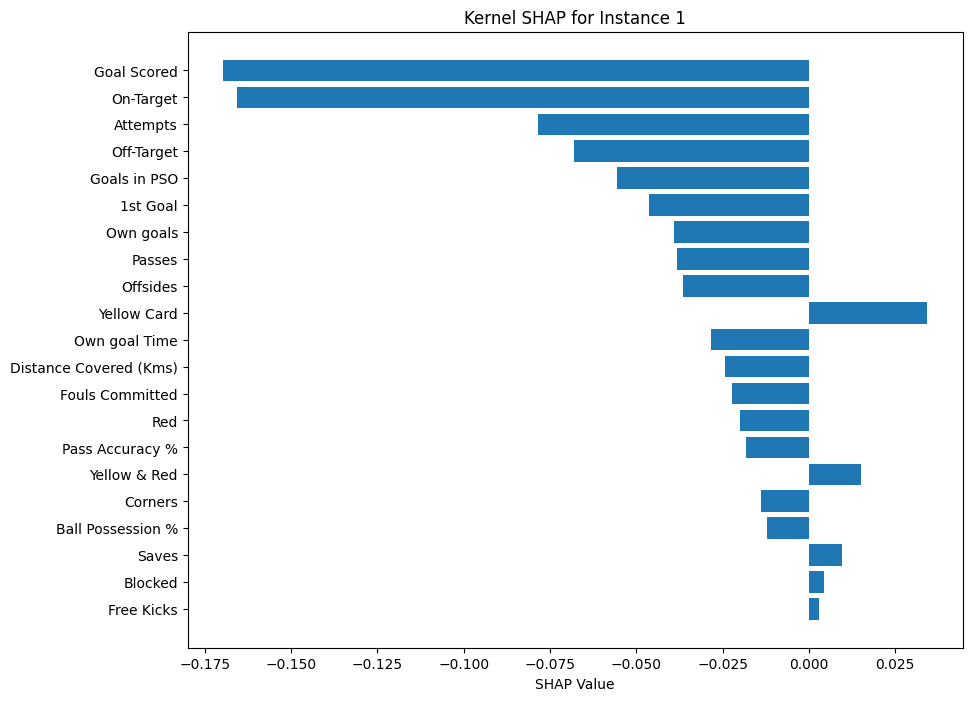

In [4]:
# Run KernelSHAP
obs_values = x_interest.values
print("Calculating Kernel SHAP values (this may take a moment)...")
final_shap_values, base_value = kernel_shap(obs_values, X_imputed, 1000, lambda x: clf.predict_proba(x)[:, 1])

# Display Results
feature_names = X.columns
results = list(zip(feature_names, final_shap_values))
results.sort(key=lambda x: abs(x[1]), reverse=True)

print(f"\nBase Value (Average Prediction): {base_value:.4f}")
print(f"Final Prediction: {pred_prob:.4f}")
print(f"Sum of SHAP + Base: {sum(final_shap_values) + base_value:.4f}")
print("\nKernel SHAP Feature Importance:")
for f, v in results:
    print(f"{f:<25} | {v:.6f}")

# Plot
plt.figure(figsize=(10, 8))
plt.barh([x[0] for x in results[::-1]], [x[1] for x in results[::-1]])
plt.xlabel("SHAP Value")
plt.title(f"Kernel SHAP for Instance {instance_idx}")
plt.show()

## Interprétation des résultats Kernel SHAP (Instance 1)

### 1. Quelle caractéristique contribue le plus à augmenter la probabilité d'avoir le "Man of the Match" ?
La caractéristique qui contribue le plus positivement est **Yellow Card** (+0.0343), suivie de **Yellow & Red** (+0.0151) et **Saves** (+0.0096).  
Ce sont les variables avec les **valeurs SHAP positives les plus élevées**.

---

### 2. Quelle caractéristique contribue le plus à la diminuer ?
La caractéristique qui diminue le plus la probabilité est **Goal Scored** (−0.1697), suivie de **On-Target** (−0.1657) et **Attempts** (−0.0786).  
Ce sont les contributions négatives les plus importantes en valeur absolue.

---

### 3. Comment la somme des valeurs SHAP mène-t-elle de la prédiction moyenne à la prédiction finale ?
La prédiction finale est obtenue en additionnant la **valeur de base** du modèle (0.84) avec la **somme des valeurs SHAP** de toutes les caractéristiques.  
La somme des contributions négatives domine, ce qui fait passer la prédiction de **0.84 à 0.07**.

---

### 4. En quoi les valeurs SHAP fournissent-elles une explication locale et additive ?
- **Locale** : les valeurs SHAP expliquent uniquement la prédiction de cette instance précise.
- **Additive** : chaque caractéristique apporte une contribution chiffrée, et leur somme reconstitue exactement la prédiction finale.

---

### 5. Comment l'importance locale SHAP diffère-t-elle de l'importance globale ?
L’importance globale mesure l’effet moyen d’une variable sur l’ensemble des données, tandis que **SHAP explique l’impact réel d’une variable pour un individu précis**.  
Une variable peut être globalement importante mais localement peu influente, ou l’inverse.

---

### 6. Impact de `nr_samples` sur la stabilité et le temps de calcul
- **Temps de calcul** : augmente avec `nr_samples`.
- **Stabilité** : plus `nr_samples` est élevé, plus les valeurs SHAP sont stables et proches des vraies valeurs de Shapley.

---

### 7. Deux limites de l’utilisation de SHAP
1. **Hypothèse d’indépendance des variables** : peut générer des combinaisons irréalistes lorsque les features sont corrélées.
2. **Coût de calcul élevé**, surtout pour KernelSHAP avec un grand nombre de variables.

---

### 8. Interprétation métier (football) des deux caractéristiques les plus influentes
- **Goal Scored (impact négatif fort)** : le joueur ou son équipe a marqué moins de buts que ce qui est attendu pour un Homme du Match, ce qui réduit fortement ses chances.
- **On-Target (impact négatif fort)** : peu de tirs cadrés, indiquant une faible contribution offensive directe, défavorable pour l’attribution du titre.
